<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#内核岭回归" data-toc-modified-id="内核岭回归-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>内核岭回归</a></span></li></ul></div>

# 内核岭回归

Kernel ridge regression (KRR)（内核岭回归）由使用内核方法的`ridge_regression`（岭回归）（使用 l2 正则化的最小二乘法）所组成。因此，它所学习到的在空间中不同的线性函数是由不同的内核和数据所导致的。对于非线性的内核，它与原始空间中的非线性函数相对应。

由KernelRidge学习的模型的形式与支持向量回归( SVR ) 是一样的。但是他们使用不同的损失函数：内核岭回归（KRR）使用 squared error loss （平方误差损失函数）而 support vector regression （支持向量回归）（SVR）使用 ε-insensitive loss ( ε-不敏感损失 )，两者都使用 l2 regularization （l2 正则化）。与 SVR 相反，拟合 KernelRidge 可以以 closed-form （封闭形式）完成，对于中型数据集通常更快。另一方面，学习的模型是非稀疏的，因此比 SVR 慢， 在预测时间上，SVR 学习了ε > 0 的稀疏模型。

下图比较了人造数据集上的 KernelRidge 和 SVR 的区别，它由一个正弦目标函数和每五个数据点产生一个强噪声组成。图中分别绘制了由 KernelRidge 和 SVR 学习到的回归曲线。两者都使用网格搜索优化了 RBF 内核的 complexity/regularization （复杂性/正则化）和 bandwidth （带宽）。它们的 learned functions （学习函数）非常相似;但是，拟合 KernelRidge 大约比拟合 SVR 快七倍（都使用 grid-search ( 网格搜索 ) ）。然而，由于 SVR 只学习了一个稀疏模型，所以 SVR 预测 10 万个目标值比使用 KernelRidge 快三倍以上。SVR 只使用了百分之三十的数据点做为支撑向量。

下图显示不同大小训练集的 KernelRidge 和 SVR 的 fitting （拟合）和 prediction （预测）时间。 
- 对于中型训练集（小于 1000 个样本），拟合 KernelRidge 比 SVR 快; 然而，对于更大的训练集 SVR 通常更好。 
- 关于预测时间，由于学习的稀疏解，SVR 对于所有不同大小的训练集都比 KernelRidge 快。 注意，稀疏度和预测时间取决于 SVR 的参数 ε 和 C ; ε = 0 将对应于密集模型。


`kernel_ridge`  
sklearn.kernel_ridge.KernelRidge(alpha=1, kernel=’linear’, gamma=None, degree=3, coef0=1, kernel_params=None)

SVR complexity and bandwidth selected and model fitted in 0.889 s
KRR complexity and bandwidth selected and model fitted in 1.676 s
Support vector ratio: 0.320
SVR prediction for 100000 inputs in 0.076 s
KRR prediction for 100000 inputs in 0.314 s


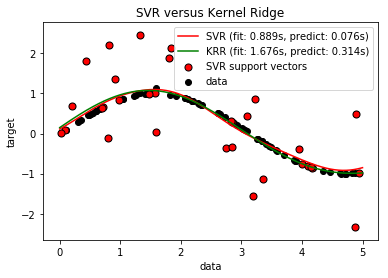

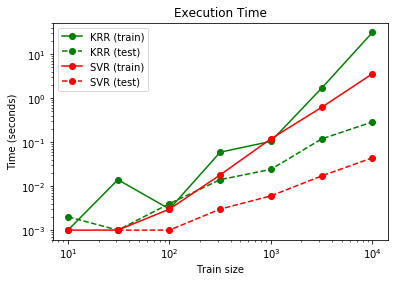

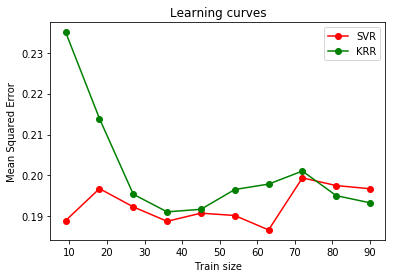

In [1]:
%matplotlib inline
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD 3 clause


from __future__ import division
import time

import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)

# #############################################################################
# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]

# #############################################################################
# Fit regression model
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)

sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], kr_predict))


# #############################################################################
# Look at the results
sv_ind = svr.best_estimator_.support_
plt.scatter(X[sv_ind], y[sv_ind], c='r', s=50, label='SVR support vectors',
            zorder=2, edgecolors=(0, 0, 0))
plt.scatter(X[:100], y[:100], c='k', label='data', zorder=1,
            edgecolors=(0, 0, 0))
plt.plot(X_plot, y_svr, c='r',
         label='SVR (fit: %.3fs, predict: %.3fs)' % (svr_fit, svr_predict))
plt.plot(X_plot, y_kr, c='g',
         label='KRR (fit: %.3fs, predict: %.3fs)' % (kr_fit, kr_predict))
plt.xlabel('data')
plt.ylabel('target')
plt.title('SVR versus Kernel Ridge')
plt.legend()

# Visualize training and prediction time
plt.figure()

# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))
sizes = np.logspace(1, 4, 7, dtype=np.int)
for name, estimator in {"KRR": KernelRidge(kernel='rbf', alpha=0.1,
                                           gamma=10),
                        "SVR": SVR(kernel='rbf', C=1e1, gamma=10)}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(sizes, train_time, 'o-', color="r" if name == "SVR" else "g",
             label="%s (train)" % name)
    plt.plot(sizes, test_time, 'o--', color="r" if name == "SVR" else "g",
             label="%s (test)" % name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title('Execution Time')
plt.legend(loc="best")

# Visualize learning curves
plt.figure()

svr = SVR(kernel='rbf', C=1e1, gamma=0.1)
kr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.1)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
train_sizes_abs, train_scores_kr, test_scores_kr = \
    learning_curve(kr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")
plt.plot(train_sizes, -test_scores_kr.mean(1), 'o-', color="g",
         label="KRR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

In [2]:
from sklearn.kernel_ridge import KernelRidge
import numpy as np
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)
clf = KernelRidge(alpha=1.0)
clf.fit(X, y) 

KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)